In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import make_pipeline, make_union, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

## Importamos y exploramos el Dataset

In [3]:
data = pd.read_csv('../data/student-por.csv')
data.head(5)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


Inspecciono Dataset

In [4]:
#print data properties
print('Data Shape: {}'.format(data.shape))
display(data.describe())
display(data.info())

Data Shape: (649, 33)


,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000
mean,16.744222,2.514638,2.306626,1.568567,1.930663,0.221880,3.930663,3.180277,3.184900,1.502311,2.280431,3.536210,3.659476,11.399076,11.570108,11.906009
std,1.218138,1.134552,1.099931,0.748660,0.829510,0.593235,0.955717,1.051093,1.175766,0.924834,1.284380,1.446259,4.640759,2.745265,2.913639,3.230656
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,2.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,2.000000,0.000000,10.000000,10.000000,10.000000
50%,17.000000,2.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,2.000000,11.000000,11.000000,12.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,6.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,32.000000,19.000000,19.000000,19.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    object
 1   sex         649 non-null    object
 2   age         649 non-null    int64 
 3   address     649 non-null    object
 4   famsize     649 non-null    object
 5   Pstatus     649 non-null    object
 6   Medu        649 non-null    int64 
 7   Fedu        649 non-null    int64 
 8   Mjob        649 non-null    object
 9   Fjob        649 non-null    object
 10  reason      649 non-null    object
 11  guardian    649 non-null    object
 12  traveltime  649 non-null    int64 
 13  studytime   649 non-null    int64 
 14  failures    649 non-null    int64 
 15  schoolsup   649 non-null    object
 16  famsup      649 non-null    object
 17  paid        649 non-null    object
 18  activities  649 non-null    object
 19  nursery     649 non-null    object
 20  higher    

None

## Veo distribucion de variable Target

<AxesSubplot:xlabel='G3', ylabel='count'>

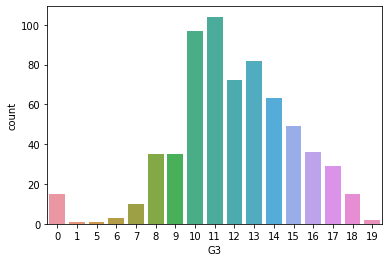

In [5]:
plt.figure()
sns.countplot(data['G3'],label="Count")

## Veo correlacion entre las variables

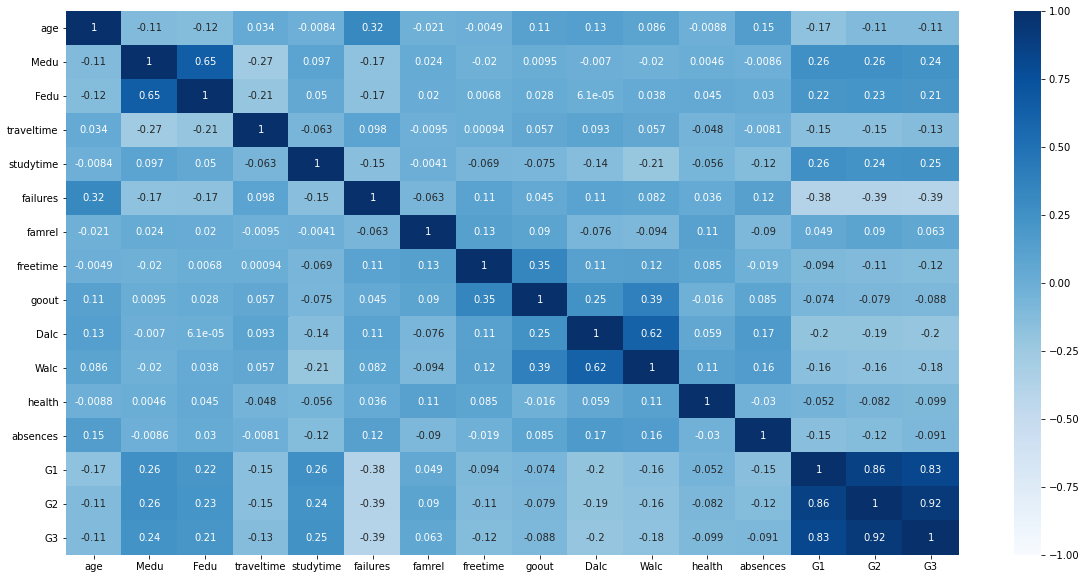

In [6]:
# ¿Qué variables están más correlacionadas con el target?
plt.figure(figsize=(20,10))
sns.heatmap(data.corr(), annot=True, vmin=-1, cmap='Blues');

## Separamos las variables independientes de la target y binarizamos la target

In [7]:
# Droppeo la variable target, aislando las independientes
X = data.drop(['G3'],axis=1)
# Binarizo la variable target, nuestro criterio le dara valor 1 a aquellos valores igual o mayores a 10 y 0 a aquellos que esten por debajo de 10
y = data.G3.apply(lambda x: 1 if x>=10 else 0)

y.value_counts()

1    549
0    100
Name: G3, dtype: int64

## Armo Funcion para seleccionar columnas Pipeline

In [8]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    
    def transform(self, X, *_):
        if isinstance(X, pd.DataFrame):
            return pd.DataFrame(X[self.columns])
        else:
            raise TypeError("Este Transformador solo funciona en DF de Pandas")
    
    def fit(self, X, *_):
        return self
    
cs = ColumnSelector('age')

cs.transform(data).head()

,age
0,18
1,17
2,15
3,15
4,16


## Selecciono columnas Numericas

In [9]:
columnasNum = X.select_dtypes([np.int64]).columns

print (columnasNum)

Index(['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel',
       'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2'],
      dtype='object')


## Armo Pipeline para estandarizar variables numericas

In [10]:
numerical_pipe = make_pipeline(ColumnSelector(columnasNum),
                         SimpleImputer(),
                         StandardScaler())

numerical_pipe.fit_transform(X)

array([[ 1.03169516,  1.31021563,  1.54071544, ...,  0.07343336,
        -4.15547029, -0.19581961],
       [ 0.21013668, -1.33603938, -1.18883229, ..., -0.35786305,
        -0.87456978, -0.19581961],
       [-1.43298028, -1.33603938, -1.18883229, ...,  0.50472977,
         0.21906372,  0.49113675],
       ...,
       [ 1.03169516, -1.33603938, -1.18883229, ...,  0.50472977,
        -0.14548078,  0.14765857],
       [ 0.21013668,  0.42813063, -1.18883229, ...,  0.50472977,
        -0.51002528, -0.53929779],
       [ 1.03169516,  0.42813063, -0.27898305, ...,  0.07343336,
        -0.51002528, -0.19581961]])

## Armo Funcion para generar Dummies Pipeline

In [11]:
class GetDummiesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    
    def transform(self, X, *_):
        if isinstance(X, pd.DataFrame):
            return pd.get_dummies(X[self.columns], columns = self.columns, drop_first = True)
        else:
            raise TypeError("Este Transformador solo funciona en DF de Pandas")
    
    def fit(self, X, *_):
        return self
    
gdt = GetDummiesTransformer(['Mjob'])
gdt.fit_transform(X).head()

,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,1,0,0,0
4,0,1,0,0


## Selecciono columnas del tipo objeto

In [12]:
columnasObj = X.select_dtypes([np.object]).columns

print (columnasObj)

Index(['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob',
       'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities',
       'nursery', 'higher', 'internet', 'romantic'],
      dtype='object')


## Armo Pipeline para columnas categoricas

In [13]:
dummies_pipe = make_pipeline(GetDummiesTransformer(columnasObj),
                             StandardScaler())

dummies_pipe.fit_transform(X)

array([[-0.73094388, -0.83337685,  0.66018233, ...,  0.34491378,
        -1.81604329, -0.76349645],
       [-0.73094388, -0.83337685,  0.66018233, ...,  0.34491378,
         0.55064767, -0.76349645],
       [-0.73094388, -0.83337685,  0.66018233, ...,  0.34491378,
         0.55064767, -0.76349645],
       ...,
       [ 1.36809408, -0.83337685,  0.66018233, ...,  0.34491378,
        -1.81604329, -0.76349645],
       [ 1.36809408,  1.19993734,  0.66018233, ...,  0.34491378,
         0.55064767, -0.76349645],
       [ 1.36809408,  1.19993734, -1.51473306, ...,  0.34491378,
         0.55064767, -0.76349645]])

## Uno los Pipeline con el metodo make_union

In [14]:
union = make_union(numerical_pipe,
                   dummies_pipe)

union.fit_transform(data.head())

array([[ 1.54348727,  1.03209369,  1.54348727,  2.        , -0.5       ,
         0.        ,  0.        ,  0.5       ,  1.75      , -0.5       ,
        -0.75      , -0.81649658,  0.68599434, -1.88740286, -1.16666667,
        -0.5       , -2.        , -0.5       , -0.5       , -0.5       ,
         2.        , -0.81649658, -0.5       ,  0.81649658,  1.22474487,
        -1.22474487, -0.5       ,  0.5       , -1.22474487, -0.5       ],
       [ 0.68599434, -1.17953565, -1.02899151, -0.5       , -0.5       ,
         0.        ,  1.58113883,  0.5       ,  0.5       , -0.5       ,
        -0.75      , -0.81649658, -0.17149859, -0.0410305 , -1.16666667,
        -0.5       ,  0.5       , -0.5       , -0.5       , -0.5       ,
        -0.5       , -0.81649658, -0.5       , -1.22474487, -0.81649658,
         0.81649658, -0.5       , -2.        ,  0.81649658, -0.5       ],
       [-1.02899151, -1.17953565, -1.02899151, -0.5       , -0.5       ,
         0.        ,  0.        ,  0.5       , -0

## Separo en Entrenamiento y Prueba

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=7)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((486, 32), (163, 32), (486,), (163,))

## Probamos con Regresion Logistica

In [16]:
pipeline = Pipeline([('union', union), 
                     ('clasificador', LogisticRegression(solver='liblinear'))])

parameters = {'clasificador__penalty': ['l1', 'l2'],
              'clasificador__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

In [17]:
from sklearn.model_selection import StratifiedKFold

folds=StratifiedKFold(n_splits=5,shuffle=True, random_state=42)

grid_search = GridSearchCV (pipeline, parameters,cv=folds, n_jobs = 5)

In [18]:
grid_search.fit(pd.DataFrame(X_train, columns=X.columns), y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('union',
                                        FeatureUnion(transformer_list=[('pipeline-1',
                                                                        Pipeline(steps=[('columnselector',
                                                                                         ColumnSelector(columns=Index(['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel',
       'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2'],
      dtyp...
                                                                                         GetDummiesTransformer(columns=Index(['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob',
       'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities',
       'nursery', 'higher', 'internet', 'romantic'],
      dtype='object'))),
                                                      

In [19]:
print("Best score: %0.3f" % grid_search.best_score_) 
print("Best parameters set:" )
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted (parameters . keys()): 
                    print("\t %s: %r" % (param_name, best_parameters[param_name])) 

Best score: 0.924
Best parameters set:
	 clasificador__C: 0.1
	 clasificador__penalty: 'l1'


In [20]:
y_pred = grid_search.best_estimator_.predict(X_test)

In [21]:
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.62      0.74        26
           1       0.93      0.99      0.96       137

    accuracy                           0.93       163
   macro avg       0.94      0.80      0.85       163
weighted avg       0.93      0.93      0.93       163

0.9325153374233128


Text(33.0, 0.5, 'Reales')

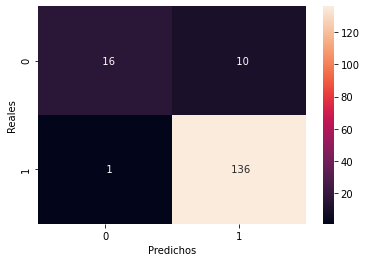

In [22]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='4d')
plt.xlabel('Predichos')
plt.ylabel('Reales')

## Probamos con Naive Bayes

In [23]:
pipeline = Pipeline([('union', union), 
                     ('clasificador', GaussianNB())])

parameters = {'clasificador__priors': [None],
              'clasificador__var_smoothing': [0.00000001, 0.000000001, 0.00000001]}
                    

In [24]:
from sklearn.model_selection import StratifiedKFold

folds=StratifiedKFold(n_splits=5,shuffle=True, random_state=42)

grid_search = GridSearchCV (pipeline, parameters,cv=folds, n_jobs = 5)

In [25]:
grid_search.fit(pd.DataFrame(X_train, columns=X.columns), y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('union',
                                        FeatureUnion(transformer_list=[('pipeline-1',
                                                                        Pipeline(steps=[('columnselector',
                                                                                         ColumnSelector(columns=Index(['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel',
       'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2'],
      dtyp...
                                                                                         GetDummiesTransformer(columns=Index(['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob',
       'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities',
       'nursery', 'higher', 'internet', 'romantic'],
      dtype='object'))),
                                                      

In [26]:
print("Best score: %0.3f" % grid_search.best_score_) 
print("Best parameters set:" )
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted (parameters . keys()): 
                    print("\t %s: %r" % (param_name, best_parameters[param_name])) 

Best score: 0.796
Best parameters set:
	 clasificador__priors: None
	 clasificador__var_smoothing: 1e-08


In [27]:
y_pred = grid_search.best_estimator_.predict(X_test)

In [28]:
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.77      0.70        26
           1       0.95      0.92      0.94       137

    accuracy                           0.90       163
   macro avg       0.80      0.84      0.82       163
weighted avg       0.91      0.90      0.90       163

0.8957055214723927


Text(33.0, 0.5, 'Reales')

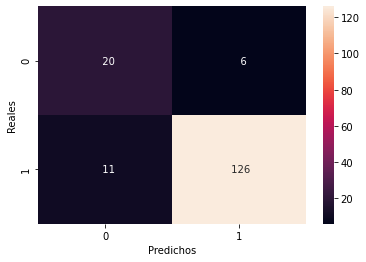

In [29]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='4d')
plt.xlabel('Predichos')
plt.ylabel('Reales')

## Probamos con Clasificacion KNN

In [30]:
pipeline = Pipeline([('union', union), 
                     ('clasificador', KNeighborsClassifier())])

parameters = {'clasificador__n_neighbors':range(2,20,2), 'clasificador__weights':['uniform','distance']}

In [31]:
from sklearn.model_selection import StratifiedKFold

folds=StratifiedKFold(n_splits=5,shuffle=True, random_state=42)

grid_search = GridSearchCV (pipeline, parameters,cv=folds, n_jobs = 5)

In [32]:
grid_search.fit(pd.DataFrame(X_train, columns=X.columns), y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('union',
                                        FeatureUnion(transformer_list=[('pipeline-1',
                                                                        Pipeline(steps=[('columnselector',
                                                                                         ColumnSelector(columns=Index(['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel',
       'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2'],
      dtyp...
                                                                                         GetDummiesTransformer(columns=Index(['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob',
       'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities',
       'nursery', 'higher', 'internet', 'romantic'],
      dtype='object'))),
                                                      

In [33]:
print("Best score: %0.3f" % grid_search.best_score_) 
print("Best parameters set:" )
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted (parameters . keys()): 
                    print("\t %s: %r" % (param_name, best_parameters[param_name])) 

Best score: 0.862
Best parameters set:
	 clasificador__n_neighbors: 6
	 clasificador__weights: 'uniform'


In [34]:
y_pred = grid_search.best_estimator_.predict(X_test)

In [35]:
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.38      0.56        26
           1       0.90      1.00      0.94       137

    accuracy                           0.90       163
   macro avg       0.95      0.69      0.75       163
weighted avg       0.91      0.90      0.88       163

0.901840490797546


Text(33.0, 0.5, 'Reales')

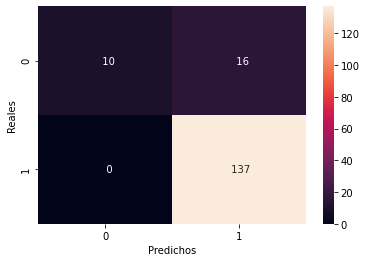

In [36]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='4d')
plt.xlabel('Predichos')
plt.ylabel('Reales')

## Graficos Adicionales

In [94]:
from sklearn.metrics import confusion_matrix

# Graficamos la matriz de confusión
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='.0f')
plt.ylabel('Notas reales')
plt.xlabel('Notas predichas');

ValueError: Found input variables with inconsistent numbers of samples: [130, 163]

In [95]:
#Combinacion consumo días de semana y fds

data['Dalc'] = data['Dalc'] + data['Walc']



Text(0.5, 0, 'Consumo de Alcohol Semanal')

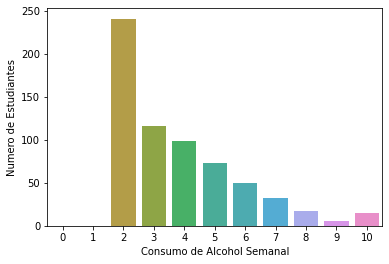

In [96]:
#numero de estudiantes vs consumo de alcohol.
list = []
for i in range(11):
    list.append(len(data[data.Dalc == i]))
ax = sns.barplot(x = [0,1,2,3,4,5,6,7,8,9,10], y = list)
plt.ylabel("Numero de Estudiantes")
plt.xlabel("Consumo de Alcohol Semanal")



Text(0.5, 0, 'Distribución de Notas por Consumo de Alcohol')

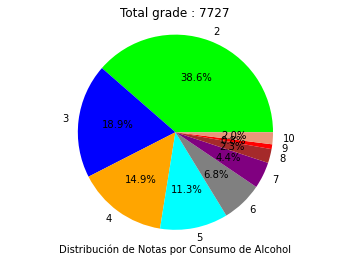

In [97]:
#distribucion de notas por consumo
labels = ['2','3','4','5','6','7','8','9','10']
colors = ['lime','blue','orange','cyan','grey','purple','brown','red','darksalmon']
explode = [0,0,0,0,0,0,0,0,0]
sizes = []
for i in range(2,11):
    sizes.append(sum(data[data.Dalc == i].G3))
total_grade = sum(sizes)
average = total_grade/float(len(data))
plt.pie(sizes,explode=explode,colors=colors,labels=labels,autopct = '%1.1f%%')
plt.axis('equal')
plt.title('Total grade : '+str(total_grade))
plt.xlabel("Distribución de Notas por Consumo de Alcohol")



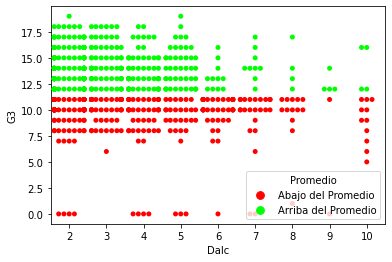

In [98]:
#Para poder entender si el alcohol afecta las notas, comparamos con los promedios.
ave = sum(data.G3)/float(len(data))
data["Linea Promedio"] = ave
data["Promedio"] = ["Arriba del Promedio" if i > ave else "Abajo del Promedio" for i in data.G3]
sns.swarmplot(x='Dalc', y = 'G3', hue = "Promedio",data= data,palette={"Arriba del Promedio":'lime', "Abajo del Promedio": 'red'})
plt.savefig('graph.png')



In [99]:
#promedio de examen final
sum(data[data.Dalc == 2].G3)/float(len(data[data.Dalc == 2]))



12.369294605809129

Text(0.5, 0, 'Weekly alcohol consumption')

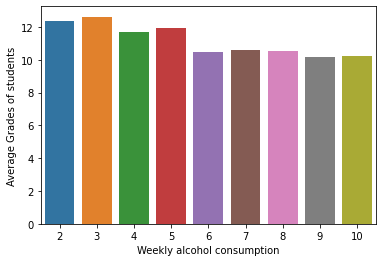

In [100]:
#Promedio notas
list = []
for i in range(2,11):
    list.append(sum(data[data.Dalc == i].G3)/float(len(data[data.Dalc == i])))
ax = sns.barplot(x = [2,3,4,5,6,7,8,9,10], y = list)
plt.ylabel('Average Grades of students')
plt.xlabel('Weekly alcohol consumption')